In [1]:
%load_ext autoreload
%autoreload 2

#per la riproducibilità
%env CUBLAS_WORKSPACE_CONFIG=":4096:8"

import os
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx



from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, new_parameters_linears
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from config_valid import Config, TrainingMode
import experiments
from experiments import Experiments, experiment_node_embedding, all_seeds
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, get_metrics, plot_node_emb_1D_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))

def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

env: CUBLAS_WORKSPACE_CONFIG=":4096:8"


In [4]:
import torch
torch.__version__

# gestisce la sorgente di randomicità
all_seeds()


# Classification CM power law, init weights

In [3]:
config_file = "configurations/classification_cm.yml"
trainer, config_c = init_all(config_file)

Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.95it/s]

Tempo impiegato: 4.78862190246582


In [187]:
with open('dataset_25nov_goodcorr.pickle', 'wb') as handle:
    pickle.dump(trainer.dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Plot del grafo

Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot


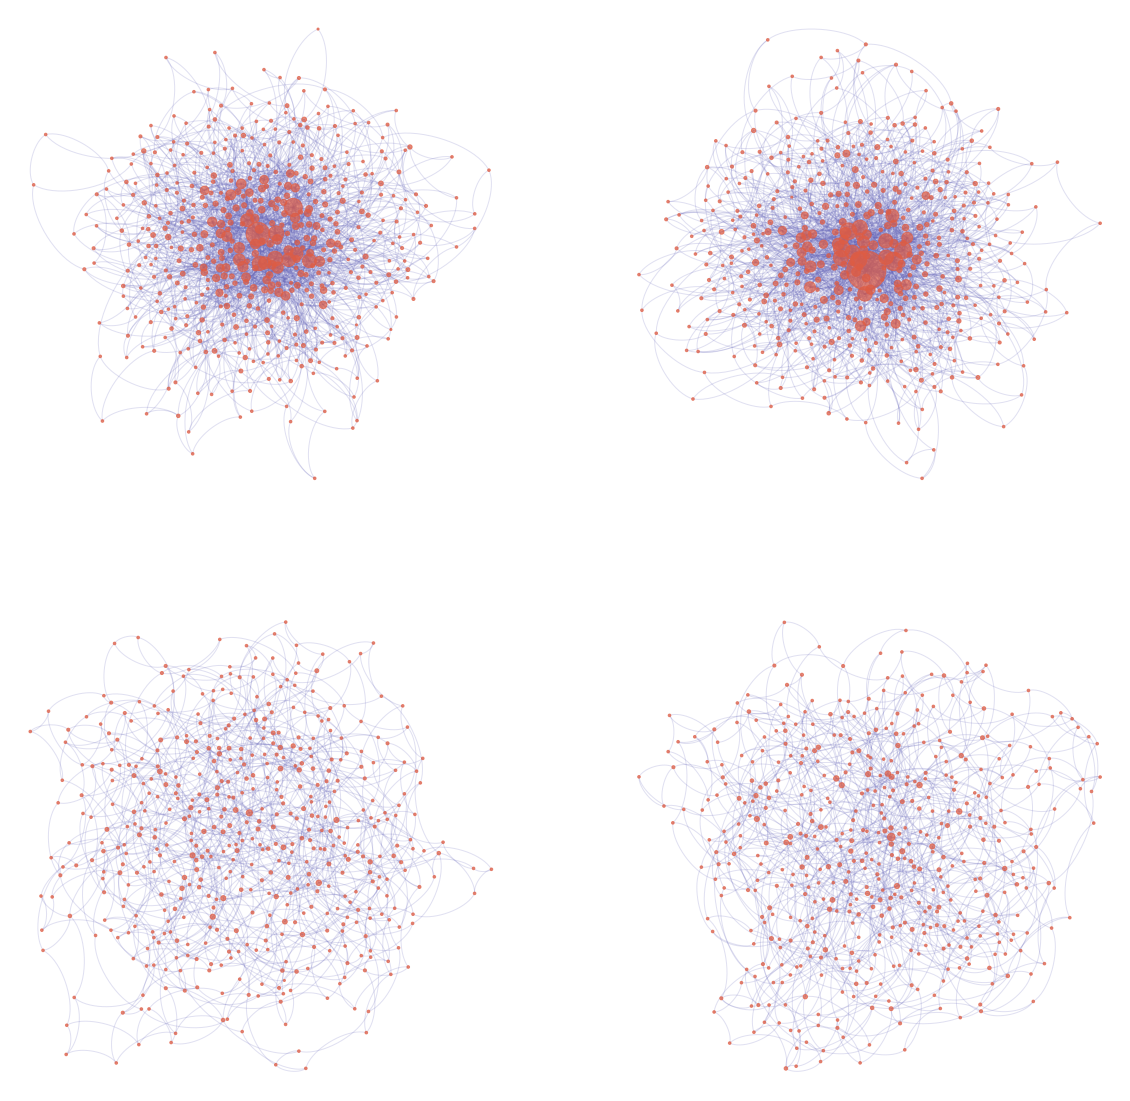

In [7]:
col = 2
rig = 2
fig, assi = plt.subplots(col,rig, figsize=(20,20))
for i in range(rig):
    for j in range(col):
        g = dataset.dataset_list[i*200+j]
        plot_grafo(assi[i][j], g, iterations=1000)
        #print(f"i {i}, j {j}")
#fig.savefig("griglia_grafi.png", dpi=100)

fig, axs = plt.subplots(ncols=2, nrows=1)
G1 = dataset.dataset_list[50]
plot_grafo(axs[0], G1, iterations=1000)   
G2 = dataset.dataset_list[270]
plot_grafo(axs[1], G2, iterations=1000)   

#fig.savefig("2grafi.png", dpi=72)

#### Se voglio inizializzare il modello con parametri specifici

In [14]:
#print("Parametri attuali")
#view_parameters(model)
print("Cambio i parametri...")
new_par = new_parameters(trainer.model, method=Inits.xavier_uniform)#, method='esn')
#print(new_par)
model = init_model_with_weights(config_c, new_par)
trainer.load_model(model)
#print("Parametri nuovi")
#view_parameters(model)

Cambio i parametri...


In [58]:
with open('init_parameters.pickle', 'wb') as handle:
    pickle.dump(new_par, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Se voglio inserire nel Trainer nuovi parametri cambiati nel config

In [5]:
config_c = Config(config_file)
trainer.reinit_conf_file(config_file)

In [4]:
trainer.launch_training(verbose=1)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data()

runs/lr-0.01_epochs1000_bs100_neurons-1-32-32-16-110-10-1_25Nov_16-30-45
Run training for 1000 epochs


 22%|██████████████████▋                                                                    | 215/1000 [00:29<01:49,  7.18it/s]


Early stopping!!!
Epoch: 215	Test loss: 4.109783427945028e-06 		 FINE TRAINING


In [124]:
embs_by_class = elaborate_embeddings(config_c, graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, trainer)

label distinte: 0
label distinte: 1


## Plot training data degree sequence histogram

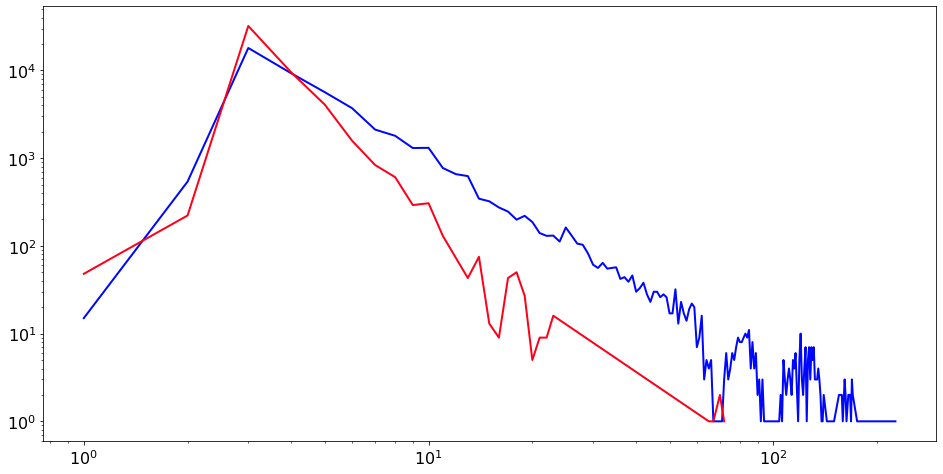

In [157]:
for embclass in embs_by_class:
    all_nodelabel = [e.node_label for e in embclass]
    counts = np.unique(all_nodelabel, return_counts=True)
    plt.loglog(*counts)#, c='blue')#, alpha=0.1)
#all_nodelabel = [e.node_label for e in emb_perclass1]
#counts = np.unique(all_nodelabel, return_counts=True)
#plt.loglog(*counts, c='red')#, alpha=0.1)

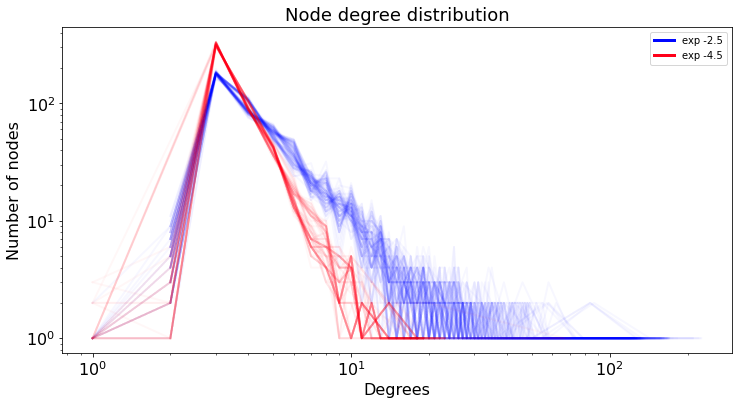

In [145]:
plot_data_degree_sequence(config_c, embs_by_class)

# TODO: affiancara al plot sopra quello in basso a sinistra, e sotto affiancare un istogramma degli embedding, in modo che sia simile e confrontabile all'istogramma di sopra

## Plot embedding ordered degrees and training data ordered degrees

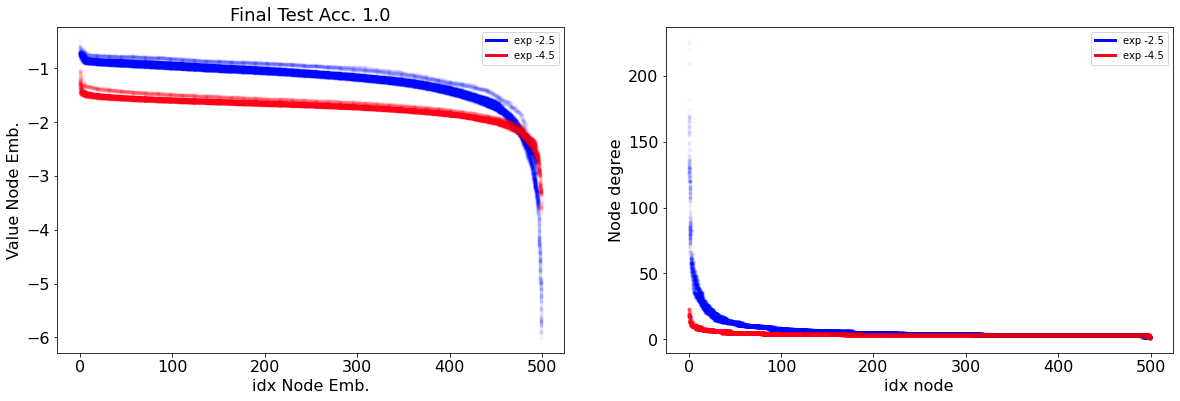

In [150]:
plot_node_emb_1D_perclass(embs_by_class, trainer.last_accuracy, config_c)

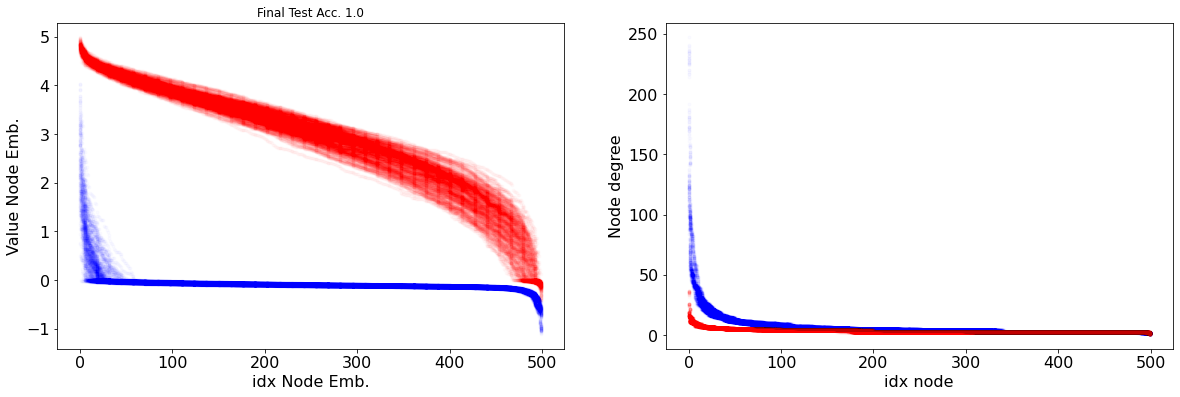

## Scatter del node embedding vs degree sequence

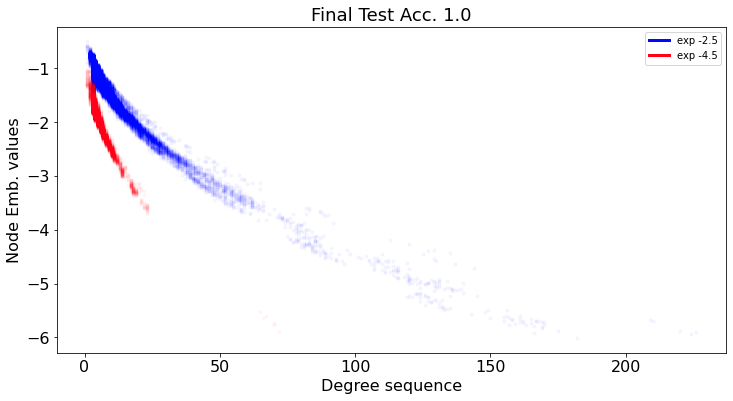

In [153]:
scatter_node_emb(embs_by_class, trainer.last_accuracy, config_c)

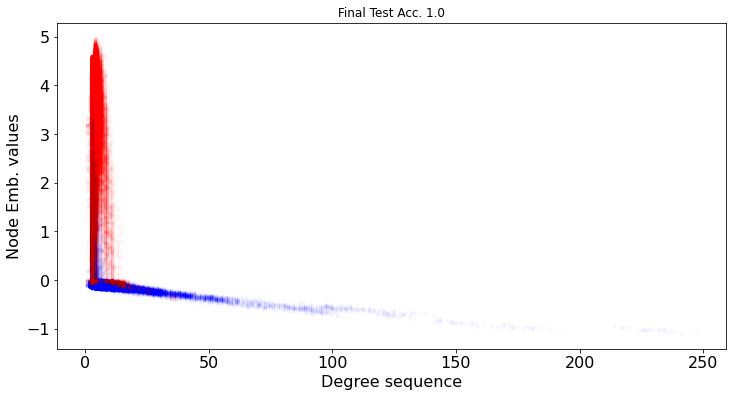

### Graph embedding histogram

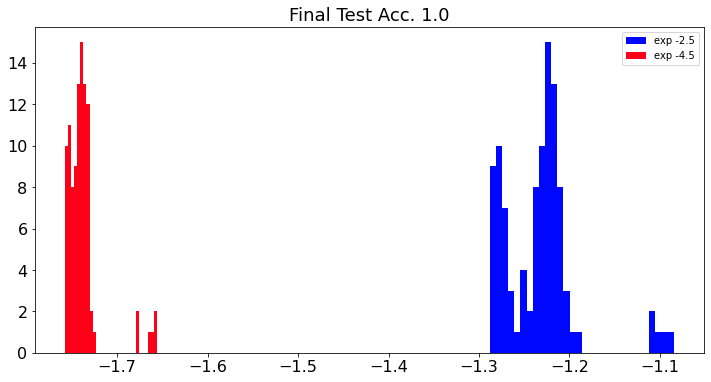

In [160]:
plot_graph_emb_1D(embs_by_class, trainer.last_accuracy, config_c)

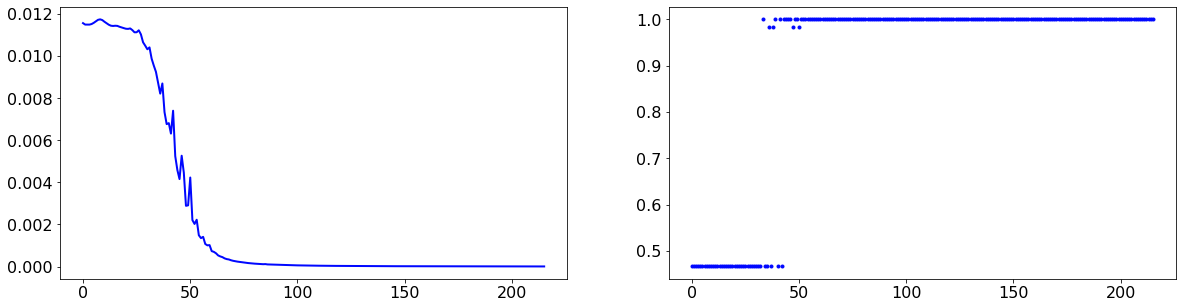

In [161]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(trainer.test_loss_list)
ax2.plot(trainer.accuracy_list, '.')
#ax2[0].hist(np.array(trainer.output_per_epoch[10]).flatten(), bins=50);

### Stessi plot a una data epoca

In [163]:
epoca=10
graph_embeddings_array_epoca = trainer.graph_embedding_per_epoch[epoca]
node_embeddings_array_epoca = trainer.node_embedding_per_epoch[epoca]
embs_by_class = elaborate_embeddings(config_c, graph_embeddings_array_epoca, node_embeddings_array_epoca, node_embeddings_array_id, trainer)

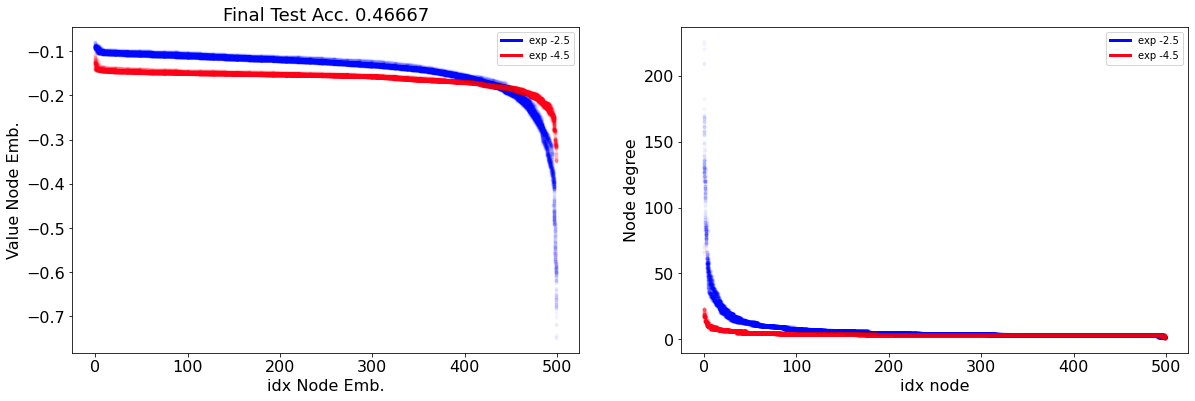

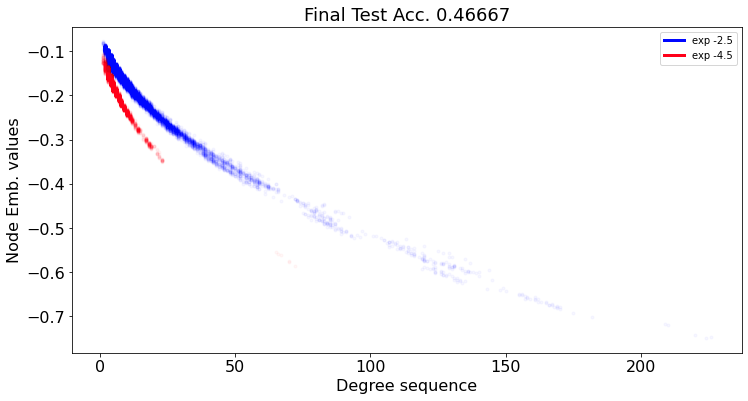

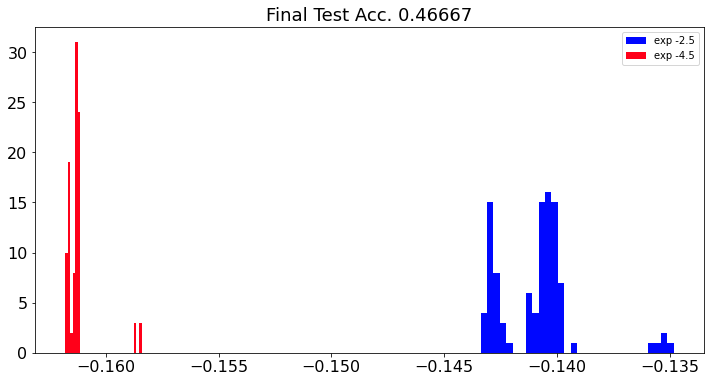

In [165]:
plot_node_emb_1D_perclass(embs_by_class, trainer.accuracy_list[epoca], config_c)
scatter_node_emb(embs_by_class, trainer.accuracy_list[epoca], config_c)
plot_graph_emb_1D(embs_by_class, trainer.accuracy_list[epoca], config_c)

In [169]:
experiments.t = trainer
experiments.c = config_c
nomefile = make_video(skip=1, fromfiles=True)

scatter_exp[-2.5_-4.5]_nodi[500_500]_grafi200_percent0.7_mode2_layers[1_32_32_16_1]_finaldenseTrue_freezedFalse


<img src="scatter_exp[-2.5_-4.5]_nodi[500_500]_grafi200_percent0.7_mode2_layers[1_32_32_16_1]_finaldenseTrue_freezedFalse.gif" width="1200" align="center">

In [25]:
batch = trainer.dataset.sample_dummy_data()
d = plot_model(trainer.model, batch, "gcn_dense")

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch/jit/_trace.py:983: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the repeated trace. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1 / 1 (100.0%)
Greatest absolute difference: 2.777576446533203e-05 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 4.7257924829475966e-05 at index (0, 0) (up to 1e-05 allowed)

  _check_trace(


aten::new_zeros %index.19 : Long(75000, strides=[1], requires_grad=0, device=cuda:0) = aten::new_zeros(%729, %580, %581, %582, %583, %584) # /home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/nn/aggr/base.py:56:0



# Verifico loss 

In [16]:
insp = Inspect(model, trainer)

In [17]:
insp.results()

total_loss    : 4.522196832112968e-07
total_loss mia: 4.512873601925094e-07
Loss with shuffled targets
total_loss:     0.049245703220367434
total_loss mia: 0.04851435422897339


### Il modello alla prima epoca di training ha effettivamente una loss comparabile a un vettore di previsioni tutte sbagliate

In [18]:
insp1 = Inspect(trainer.model_checkpoint, trainer)
insp1.results()

total_loss    : 0.0058114970723787945
total_loss mia: 0.0058114950855573016
Loss with shuffled targets
total_loss:     0.005811619758605957
total_loss mia: 0.005811617771784464


# Ripeto con gli stessi pesi random di partenza, ma freezando i layer GCN

### Carico lo stesso dataset e gli stessi pesi 

In [2]:
with open('init_parameters.pickle', 'rb') as file:
    previuos_par = pickle.load(file)
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file) 


In [3]:
config_file = "configurations/classification_cm.yml"
config_c = Config(config_file)
config_c.conf['model']['freezeGCNlayers'] = True

In [4]:
model = init_GCN(config_c, verbose=False)
modify_parameters(model, previuos_par)

In [5]:
trainer = Trainer(model, config_c)
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)

100%|████████████████████████████████████████████████████| 400/400 [00:12<00:00, 31.93it/s]

Tempo impiegato: 12.565143585205078


In [11]:
trainer.reinit_conf_file(config_file)
trainer.reinit_model(model)

In [6]:
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

Before training Test loss: 0.005903886258602142
Before training Training + Test loss: 0.01753023813168208
Run training for 1400 epochs
Epoch: 1399	Test loss: 0.00042852191254496577 		 FINE TRAINING
Take to cpu the embedding array 


In [7]:
node_emb_pergraph, node_embedding_class = elaborate_embedding_pergraph(config_c, graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, test_loss_list, trainer)
emb_perclass0, emb_perclass1 = separate_embedding_by_classes(node_emb_pergraph)

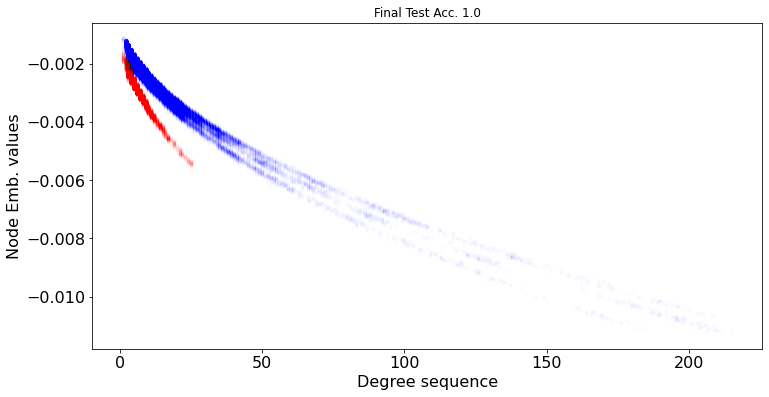

In [8]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

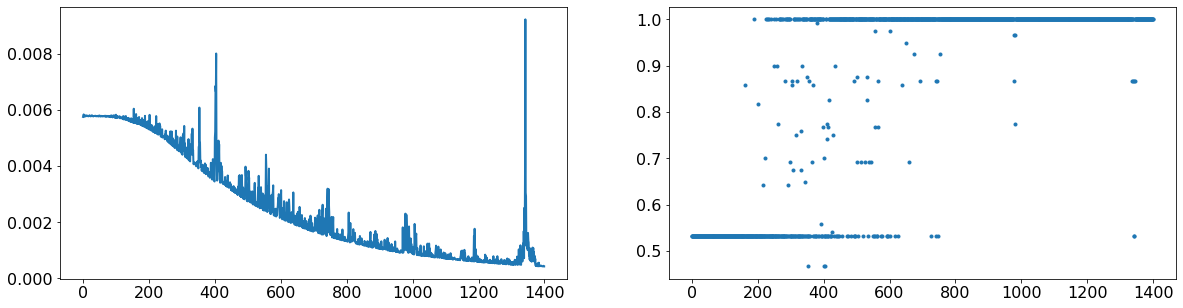

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(trainer.test_loss_list)
ax2.plot(trainer.accuracy_list, '.')

In [13]:
experiments.t = trainer
experiments.c = config_c
nomefile = make_video(skip=3, fromfiles=True)

scatter_exp[-2.5_-4.5]_nodi[700_700]_grafi400_percent0.7_mode2_layers[1_16_16_1]_finaldenseTrue_freezedTrue


<img src="scatter_exp[-2.5_-4.5]_nodi[700_700]_grafi400_percent0.7_mode2_layers[1_16_16_1]_finaldenseTrue_freezedTrue.gif" width="1200" align="center">

### Calcolo della correlazione tra node embedding e sequenza di grado

In [170]:
for embclass in embs_by_class:
    for e in embclass:
        e.get_correlation_with_degree_sequence()

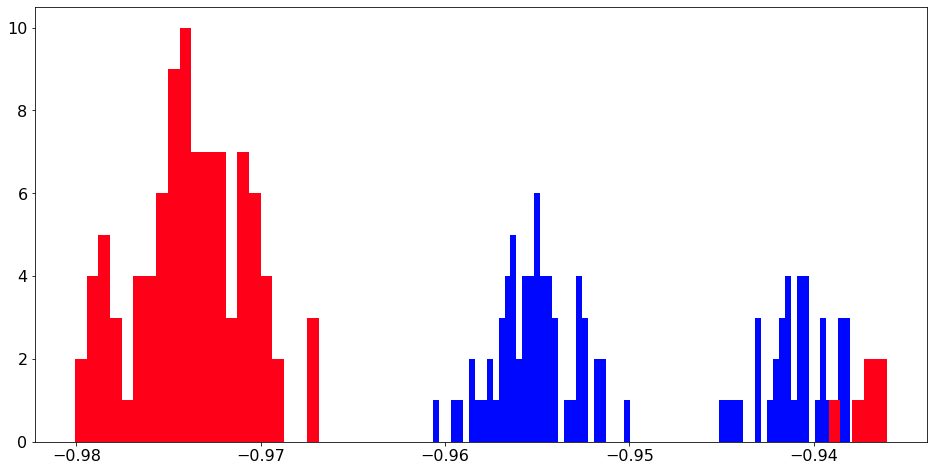

In [172]:
for embclass in embs_by_class:
    plt.hist([e.correlation_with_degree for e in embclass], bins=70);
#plt.hist([e.correlation_with_degree for e in emb_perclass1], bins=70);

In [179]:
avg_corr_classes = get_corrs_training()

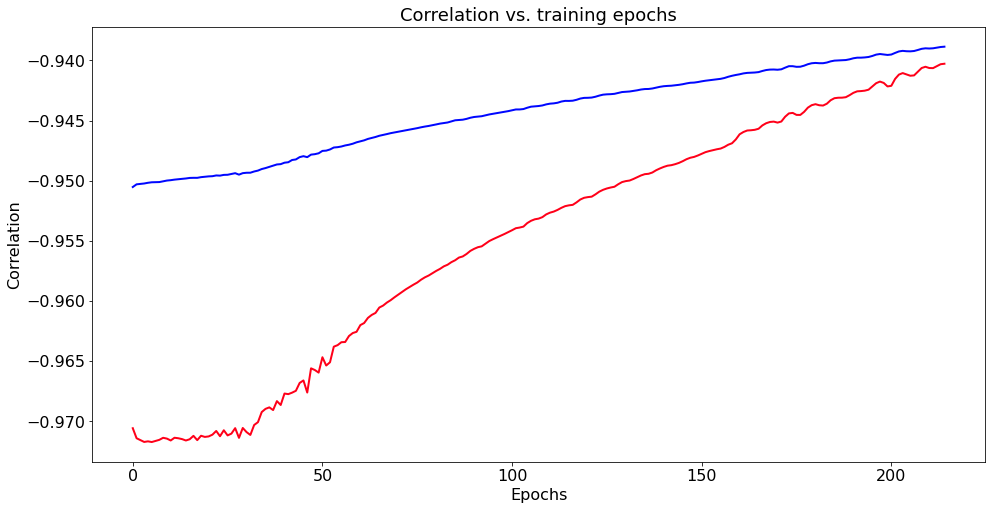

In [184]:
plot_corr_epoch(np.array(avg_corr_classes).T, config_c)

# Verifica della riproducibilità di tanti training con stessi parametri -> controllo dei random seed

In [11]:
config_file = "configurations/classification_cm-diversi_init_weights.yml"
losses = verify_two_same_trainings(config_file, tentativi=3)

Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 84.01it/s]


Tempo impiegato: 2.40040922164917


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.82it/s]


In [ ]:
config_class = Config(config_file)
trainer = Trainer(config_class)
#experiments.global_config=config_class
#experiments.global_trainer=trainer

diz_trials = {'model.init_weights': [ 'xavier_normal', 'kaiming_uniform']*4}
gc = GridConfigurations(config_class, diz_trials4)
gc.make_configs()
print(f"Farò {len(gc.configs)} training.")

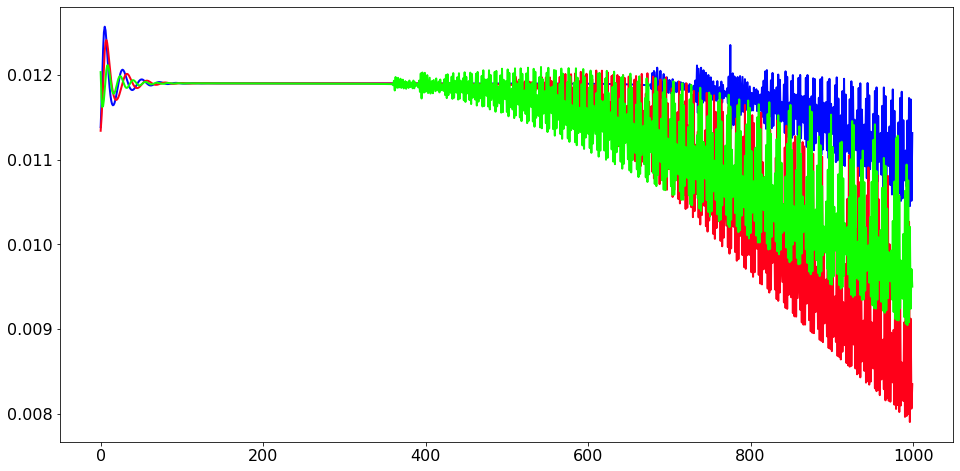

In [12]:
for l in losses:
    plt.plot(l)

## 😎 Devo controllare anche i pesi del Denso

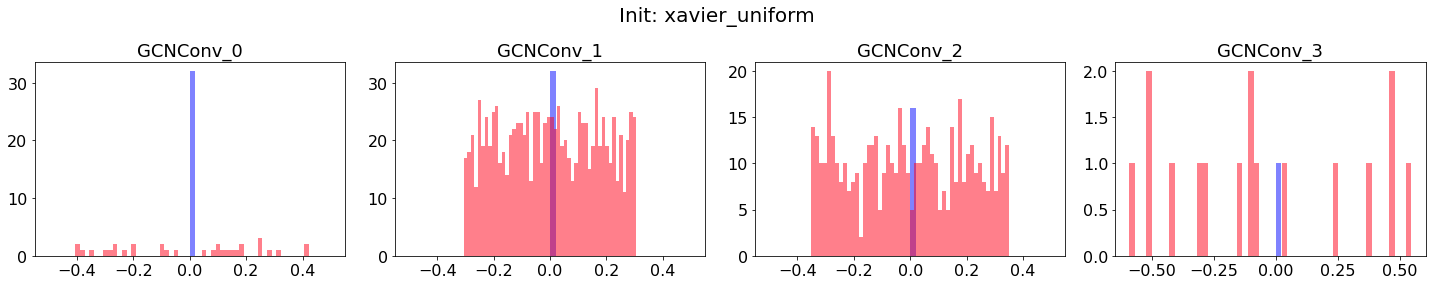

In [3]:
config_file = "configurations/classification_cm-diversi_init_weights.yml"
config_class = Config(config_file)
trainer = Trainer(config_class)
model = trainer.init_GCN()
view_parameters(model, verbose=False)

In [21]:
#plt.hist(list(model.convs[2].parameters())[1].cpu().numpy().flatten(), bins=50);

In [39]:
lin_pars = new_parameters_linears(model)

In [40]:
config_file = "configurations/classification_cm-diversi_init_weights.yml"
losses = verify_two_same_trainings(config_file, tentativi=3)

Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 91.71it/s]


Tempo impiegato: 4.401291608810425


 38%|████████████████████████████████████▏                                                           | 377/1000 [01:17<02:08,  4.86it/s]


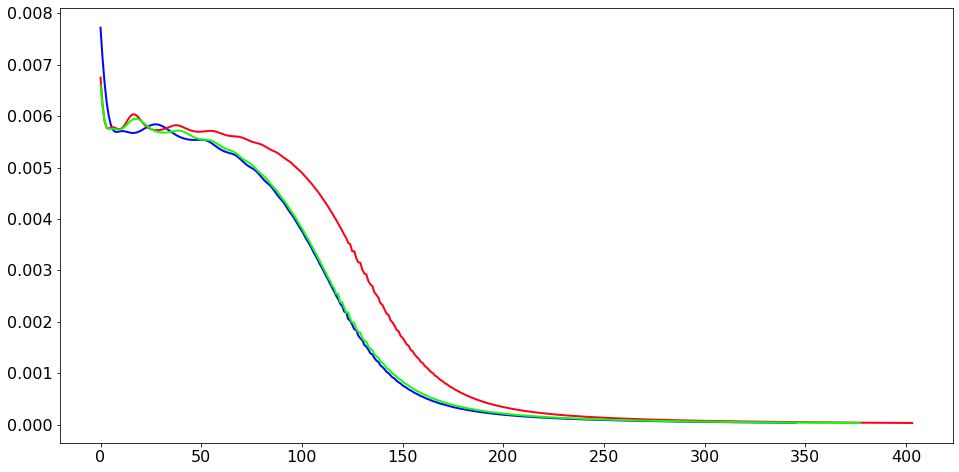

In [41]:
for l in losses:
    plt.plot(l)

### Fin qui mancava il controllo dei random seed, ora sono considerati:

In [3]:
config_file = "configurations/classification_cm-diversi_init_weights.yml"
losses = verify_two_same_trainings(config_file, tentativi=3)

Generating dataset...
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 85.00it/s]


Tempo impiegato: 4.746778249740601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:56<00:00,  8.85it/s]


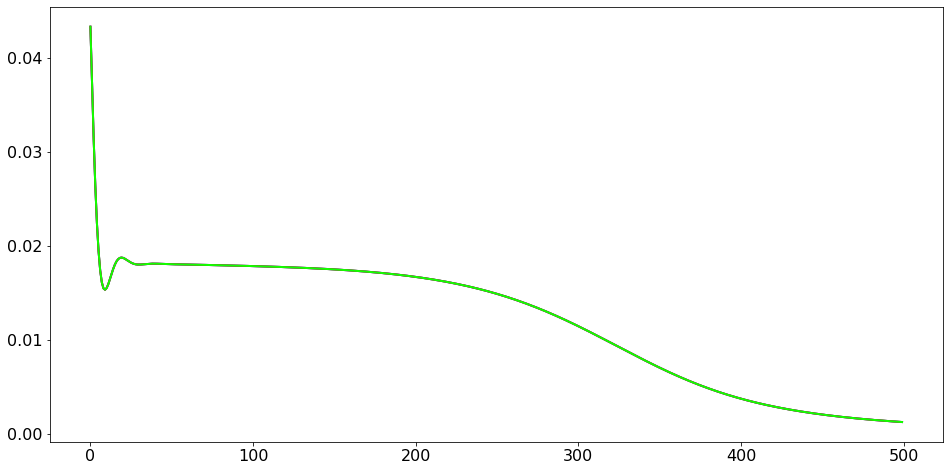

In [4]:
for l in losses:
    plt.plot(l)

# Più di due classi
Metto in difficoltà la rete per vedere un caso in cui l'embedding non risulta già separato all'inizio

In [5]:
rootsave = Path("output_plots/")
config_file = "configurations/classification_cm_manyclasses.yml"
#config_c = Config(config_file)
#trainer = Trainer(config_c)

In [6]:
xp = Experiments(config_file, rootsave)

In [7]:
xp.just_train()

Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████| 1600/1600 [00:45<00:00, 34.94it/s]


Tempo impiegato: 45.949488162994385


In [8]:
embs_by_class = xp.embedding()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


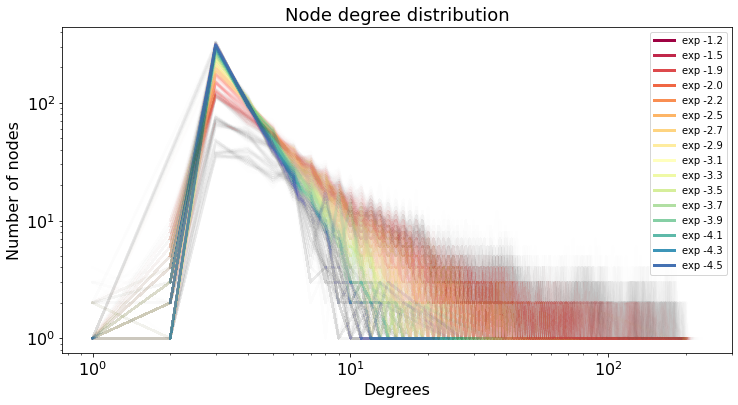

In [33]:
plot_data_degree_sequence(xp.trainer.config_class, embs_by_class, sequential_colors=True)

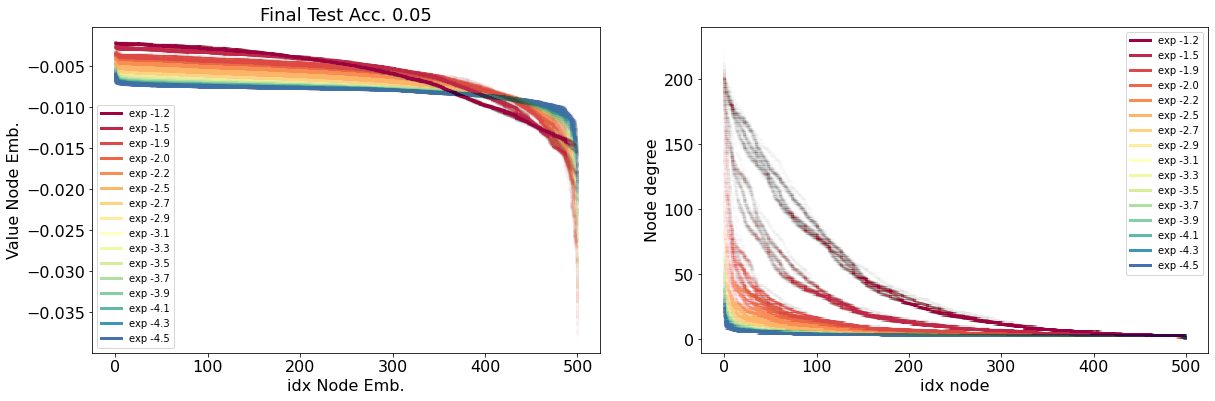

In [30]:
plot_node_emb_1D_perclass(embs_by_class, xp.trainer.last_accuracy, xp.trainer.config_class, sequential_colors=True)

/home/daniele/Documenti/Progetti/Networks/Embednet/plot_funcs.py:120: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(str_filename)
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


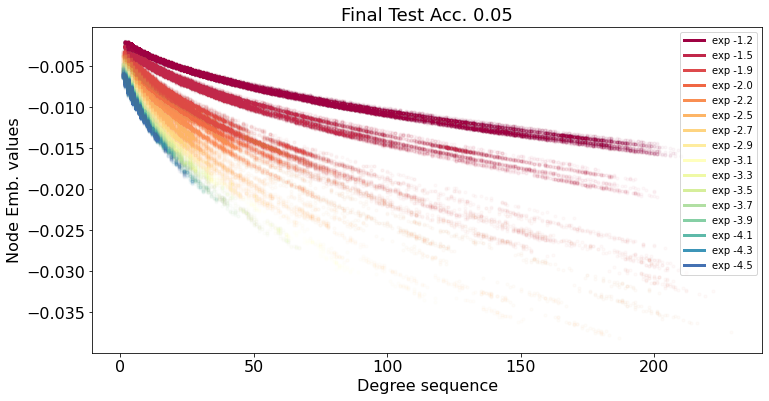

In [34]:
fname = xp.rootsave/Path("many_classes/scatter.png")
scatter_node_emb(embs_by_class, xp.trainer.last_accuracy, xp.trainer.config_class, sequential_colors=True, filename=fname)

# Vario la percentuale dello split train test set per vedere l'accuracy

In [6]:
percentage_train = [0.6, 0.2]
#mode = ['mode1', 'mode2']
#Num_nodes = [[i, i] for i in range(50, 301, 250)]
#Num_grafi_per_tipo = [i for i in range(50, 301, 250)]
list_exponents = [[-2.5, -3.5], [-2.5, -4.5]]
denso = [False, True]    
#trials = list(itertools.product(percentage_train, mode, Num_nodes, Num_grafi_per_tipo, list_exponents))
trials = list(itertools.product(percentage_train, list_exponents, denso))

In [10]:
trials

[(0.6, [-2.5, -3.5], False),
 (0.6, [-2.5, -3.5], True),
 (0.6, [-2.5, -4.5], False),
 (0.6, [-2.5, -4.5], True),
 (0.2, [-2.5, -3.5], False),
 (0.2, [-2.5, -3.5], True),
 (0.2, [-2.5, -4.5], False),
 (0.2, [-2.5, -4.5], True)]

In [8]:
import copy
def make_config(config, trials):
    configs = []
    # for lr, layer, num_nodes in trials:
    for percentage_train in trials:
        #config['graph_dataset']['list_exponents'] = list_exponents
        config['training']['percentage_train'] = percentage_train
        copia = copy.deepcopy(config)
        confclass = Config.fromdict(copia)
        configs.append(confclass)
    return configs

config_c = Config(config_file)
configs = make_config(config_c.conf, trials)

dataset, model, trainer, config_c = init(config_file)

metodo=Inits.xavier_uniform
parameters = new_parameters(model, method=metodo)
#emb_class01 = []
#trainers = []

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [9]:
for i, c in enumerate(configs):
    print(f'Run {i+1}/{len(configs)}')
    try:
        _, t = init_model_dataset(config_file)
        emb_perclass0, emb_perclass1 = run_with_weights(c, t, parameters)
        #emb_class01.append((emb_perclass0, emb_perclass1))
        c.conf['test_loss'] = t.test_loss_list
        c.conf['last_accuracy'] = t.last_accuracy
        #trainers.append(trainer)
        make_gif(metodo)
    except Exception as e: 
        print(repr(e))

Run 1/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 266.67it/s]


Tempo impiegato: 2.301841974258423
Before training Test loss: 0.01540339986483256
Run training for 250 epochs
Epoch: 249	Test loss: 5.863495171070099e-05 		 FINE TRAINING


/tmp/ipykernel_743573/1004375323.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in pictures]


Run 2/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 252.97it/s]


Tempo impiegato: 2.4172604084014893
Before training Test loss: 0.015403274363941616
Run training for 250 epochs
Epoch: 249	Test loss: 0.0001182410814281967 		 FINE TRAINING
Run 3/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 223.62it/s]


Tempo impiegato: 2.727548122406006
Before training Test loss: 0.015403295225567288
Run training for 250 epochs
Epoch: 249	Test loss: 5.936222150921821e-05 		 FINE TRAINING
Run 4/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 202.96it/s]


Tempo impiegato: 3.0207369327545166
Before training Test loss: 0.015402771366967095
Run training for 250 epochs
Epoch: 249	Test loss: 2.5668661045427953e-05 		 FINE TRAINING
Run 5/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 199.31it/s]


Tempo impiegato: 3.124682664871216
Before training Test loss: 0.01540369623237186
Run training for 250 epochs
Epoch: 249	Test loss: 0.00022047702740463947 		 FINE TRAINING
Run 6/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 229.85it/s]


Tempo impiegato: 2.6663970947265625
Before training Test loss: 0.01540232366985745
Run training for 250 epochs
Epoch: 249	Test loss: 4.887313181017008e-05 		 FINE TRAINING
Run 7/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 189.86it/s]


Tempo impiegato: 3.220322370529175
Before training Test loss: 0.01540289024511973
Run training for 250 epochs
Epoch: 249	Test loss: 7.73899787519541e-05 		 FINE TRAINING
Run 8/8
Create dataset
Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:03<00:00, 189.15it/s]


Tempo impiegato: 3.2282421588897705
Before training Test loss: 0.01540466116534339
Run training for 250 epochs
Epoch: 249	Test loss: 7.319507939327095e-05 		 FINE TRAINING


In [ ]:
for i, t in enumerate(trainers):
    try:
        c = configs[i]
        make_gif_animata(metodo)
    except Exception as e: 
        print(repr(e)) 

# Regression CM

In [9]:
config_file = "configurations/classification_cm.yml"
dataset, model, trainer, config_c = init(config_file, parallel=False)

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [12]:
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 103.99it/s]

Tempo impiegato: 3.891669988632202


In [13]:
new_par = new_parameters(model, method=Inits.xavier_uniform)#, method='esn')
modify_parameters(model, new_par)
trainer.reinit_conf_file(config_file)
trainer.reinit_model(model)

In [19]:
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

In [22]:
node_embeddings = NodeEmbedding(node_embeddings_array, node_embeddings_array_id, trainer.dataset, test_loss_list, config_c)
node_emb_pergraphclass = node_embeddings.get_emb_per_graph_class_cm(graph_embeddings_array)

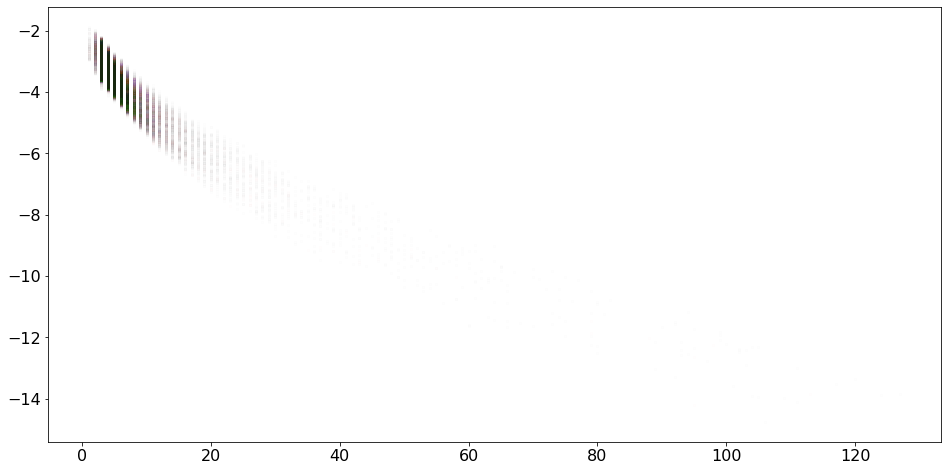

In [23]:
for emb_pergraph in node_emb_pergraphclass:
    plt.scatter(emb_pergraph.node_label, emb_pergraph.node_embedding_array, marker='.', alpha=0.005)   #TODO rifare col node label nuovo

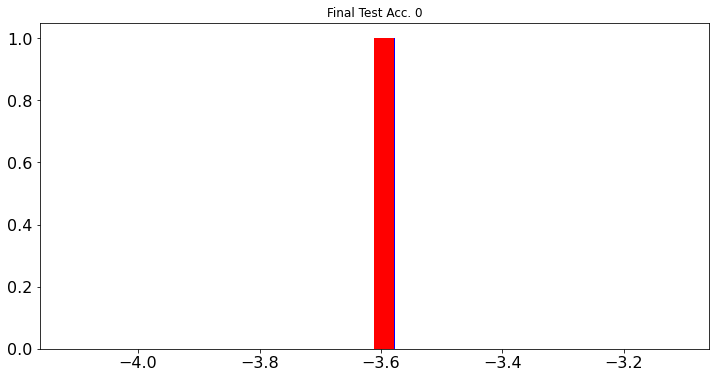

In [21]:
plot_graph_emb_1D(emb_perclass0, emb_perclass1, trainer.last_accuracy)